In [44]:
# import 
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import os
from torch.utils.data import Dataset
from librosa.feature import melspectrogram
from torch.utils.data import DataLoader
from tqdm import tqdm

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/dcase-aml/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Running on Kaggle


In [2]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


## Data Loading 


In [3]:
TRAIN_PATH = DATA_PATH + r"dev_data/dev_data/slider/train"
TEST_PATH = DATA_PATH +r"dev_data/dev_data/slider/test"

In [4]:
# Dataloader

class AudioDataset(Dataset):
    def __init__(self, data_path, train):
        self.data_path = data_path
        file_list = os.listdir(self.data_path)
        
        if train:
            self.labels = [0] * len(file_list)
        else:
            self.labels = [1 if el[0]=='a' else 0 for el in file_list]
        print(self.data_path)
        
        self.audios, self.srs= zip(*[librosa.load(os.path.join(self.data_path, path)) for path in os.listdir(self.data_path)])
        self.mfccs = [librosa.feature.mfcc(y=audio, sr=self.srs[0]) for audio in self.audios]
        self.s= melspectrogram(y=self.audios[0], sr=self.srs[0])
        print(self.s.shape)
        self.spectrograms = [melspectrogram(y=audio, sr=self.srs[0]) for audio in self.audios]
        print(self.spectrograms[0].shape)
        self.spectrograms_db = [librosa.amplitude_to_db(spec, ref=np.min) for spec in self.spectrograms]
        print(self.spectrograms_db[0].shape)
        
        
    def __len__(self):
        return len(os.listdir(self.data_path))
    

    def __getitem__(self, idx):
        audio = self.audios[idx]
        label = self.labels[idx]
        sr = self.srs[idx]
        mfcc = self.mfccs[idx]
        spec = self.spectrograms[idx]
        spec_db = self.spectrograms_db[idx]
        spec_db_flattened = spec_db.flatten()  # Flatten the spectrograms_db
        return spec_db_flattened, label

In [5]:
train_dataset = AudioDataset(data_path=TRAIN_PATH, train=True)
test_dataset = AudioDataset(data_path=TEST_PATH, train=False)
train_dataset.spectrograms[0].shape

/kaggle/input/dcase-aml/dev_data/dev_data/slider/train
(128, 431)
(128, 431)
(128, 431)
/kaggle/input/dcase-aml/dev_data/dev_data/slider/test
(128, 431)
(128, 431)
(128, 431)


(128, 431)

In [16]:
train_mean = np.mean(train_dataset.spectrograms_db, axis = 0)
#print(train_mean)
train_dev = np.std(train_dataset.spectrograms_db, axis = 0)
#print(train_dev)

train_dataset_s = (train_dataset.spectrograms_db - train_mean) / train_dev
# print(train_dataset_s)

print(len(train_dataset_s))
print(len(test_dataset))

batch_size = 8

train_loader = DataLoader(train_dataset_s, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(test_loader))

2370
1101
297
138


## Model 


In [54]:
import torch
import torch.nn as nn
import torch.nn.init as init

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(128 * 431, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
            #nn.ReLU(),
            #nn.Linear(128, 64),
            #nn.ReLU(),
            #nn.Linear(64, 30)
        )
        
        self.decoder = nn.Sequential(

            #nn.Linear(30, 64),
            #nn.ReLU(),
            #nn.Linear(64, 128),
            #nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 128 * 431),
            nn.Tanh()
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.normal_(module.weight, mean=0, std=0.01)
                if module.bias is not None:
                    init.zeros_(module.bias)

                    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input if needed
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [55]:
# Model Initialization
model = AE().to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-3,
							weight_decay = 1e-8)


In [56]:
image = train_dataset_s [0]
print(image.shape)

(128, 431)


In [57]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    
# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [58]:
# Training Loop
epochs = 100
losses = []


for epoch in range(epochs):
    epoch_loss = 0
    avg_train_loss = 0
    print(f"Starting epoch {epoch + 1}")
                     
    for i,batch in enumerate(train_loader):
        # Flatten the batch of images
        batch = batch.view(batch.size(0), -1).to(device)
        
        # Forward pass
        reconstructed = model(batch)
        
        # Compute loss
        loss = loss_function(reconstructed, batch)
        if i%100==0:
            print(loss)
        # Zero gradients, backward pass, update weights
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item()
        
        
        
    avg_epoch_loss = epoch_loss / len(train_loader)    
    losses.append(avg_epoch_loss)
    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}")
    
    if epoch == 100:
        save_checkpoint(model, optimizer, avg_train_loss, dir_checkpoint, desc)



Starting epoch 1
tensor(0.9927, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7172, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0931, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch [1/100], Loss: 0.8089
Starting epoch 2
tensor(0.5741, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8961, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7137, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch [2/100], Loss: 0.7190
Starting epoch 3
tensor(0.6574, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7059, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7012, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch [3/100], Loss: 0.6807
Starting epoch 4
tensor(0.7149, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6730, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8773, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch [4/100], Loss: 0.6476
Starting epoch 5
tensor(0.6604, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5404, device='

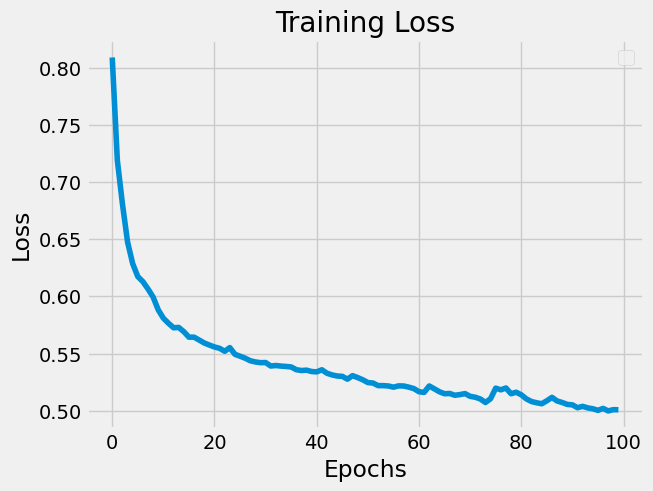

In [62]:
# Plot the loss
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(len(losses)), losses)
plt.title("Training Loss")
plt.legend()
plt.show()